In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import numba
from scipy.special import kv
import progressbar
%matplotlib inline

In [2]:
a,b,V0=2.6,0.4,8

A=0.25;A_cont=-2.32;A_SC=-0.898;alpha=0.01
NG=40; #plane-wave basis 
NK=80; #number of k-points
occupation=2 #number of electrons per unit cell
Volume=NK*(a+b) #Volume of system

In [3]:
#Soft Coloumb
def Coloumb(K,G):
#     return 4*np.pi*np.diag(1/(np.abs(K+G)**2))
    V=2*A*np.diag(kv(0,np.sqrt(alpha)*np.abs(K+G)))
    V[np.abs(V)==np.inf]=0
    return V

# DFT procedure

In [4]:
NX=1000;
X=np.linspace(0,a+b,NX+1);X=np.delete(X,-1)
G=2*np.pi*np.arange(-NG/2,NG/2)/(a+b)
K=np.arange(-NK/2,NK/2)/(a+b)*2*np.pi/NK
basis=np.exp(1j*G[None,:]*X[:,None])
Vext=basis.T.conj().dot(np.diag(V0*(X<b))).dot(basis)/NX
Ek,Dk=[],[]
bar=progressbar.ProgressBar()
for i in bar(range(NK)):
    H=Vext+np.diag(G+K[i])**2/2.
    E,D=np.linalg.eigh(H)
    Ek.append(E);Dk.append(D)
Ek=np.array(Ek);Dk=np.array(Dk)
E_Fermi=(np.min(Ek[:,occupation])+np.max(Ek[:,occupation-1]))/2
E_Gap=np.min(Ek[:,occupation])-np.max(Ek[:,occupation-1])

100% |########################################################################|


Text(0,0.5,'E')

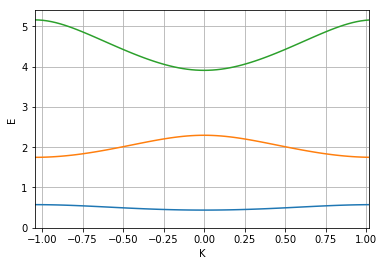

In [5]:
plt.figure()
for i in range(3):
    plt.plot(K,Ek[:,i].real,'-')
plt.ylim([0,None])
plt.xlim([np.min(K),np.max(K)])
plt.grid()
plt.xlabel('K');plt.ylabel('E')

In [6]:
print r'E_Fermi = '+str(E_Fermi)
print r'E_Gap = '+str(E_Gap)

E_Fermi = 3.10012430071429
E_Gap = 1.610088120950817


# Transition matrix elements

In [7]:
indexes=[(n,k) for n,k in product(range(NG/2),range(NK))]
N=len(indexes)

rho=np.zeros((N,N,NG),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    n1,k1=indexes[i1]
    for i2 in range(i1,N):
        n2,k2=indexes[i2]
        wf1=np.fft.ifft(Dk[k1,:,n1])
        wf2=np.fft.ifft(Dk[k2,:,n2])
        rho[i1,i2]=np.fft.fftshift(np.fft.fft(wf2*wf1.conj()))*NG    
        rho[i2,i1]=rho[i1,i2].conj()

100% |########################################################################|


# RPA-susceptibility and Screened Potential

In [8]:
K_index=np.arange(-NK,NK)
def find_q(k1,k2):
    return np.where(K_index==(k1-k2))[0]
q=np.zeros((NK,NK))
for i in range(NK):
    for j in range(NK):
        q[i,j]=int(find_q(i,j)[0])      

indexes=[(n,k) for n,k in product(range(NG/2),range(NK))]
N=len(indexes)
K_full=np.arange(-NK,NK)/(a+b)*2*np.pi/NK

chi0=np.zeros((2*NK,NG,NG),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    n1,k1=indexes[i1]
    f1=int(Ek[k1,n1]<=E_Fermi)
    for i2 in range(N):
        n2,k2=indexes[i2]
        f2=int(Ek[k2,n2]<=E_Fermi)
        if (f1-f2)!=0 and q[k1,k2]!=np.inf:
            element=2*(f1-f2)
            element*=rho[i1,i2,:,None]*rho[i1,i2,None,:]
            element/=Ek[k1,n1]-Ek[k2,n2]
            chi0[int(q[k1,k2])]+=element
            
V=np.zeros((2*NK,NG,NG))
for i in range(2*NK):
    V[i]=Coloumb(K_full[i],G)
V[V==np.inf]=0


chi0/=(Volume*occupation)
W=np.zeros_like(chi0)
epsilon=np.zeros_like(chi0)
bar=progressbar.ProgressBar()
for i in bar(range(2*NK)):
    epsilon[i]=np.eye(NG)-np.dot(V[i],chi0[i])
    W[i]=np.dot(np.linalg.inv(epsilon[i]),V[i])

100% |########################################################################|
100% |########################################################################|


/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,0,'K')

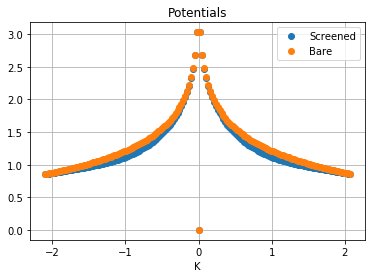

In [9]:
plt.title('Potentials')
plt.plot(K_full,W[:,NG/2,NG/2],'o',label='Screened')
plt.plot(K_full,V[:,NG/2,NG/2],'o',label='Bare')
plt.grid()
plt.legend(loc='best')
plt.xlabel('K')

Text(0.5,0,'K')

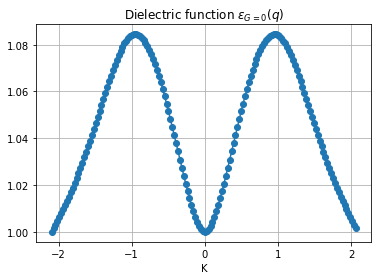

In [10]:
plt.title('Dielectric function $\epsilon_{G=0}(q)$')
plt.plot(K_full,epsilon[:,NG/2,NG/2],'-o')
plt.grid()
plt.xlabel('K')

# TDDFT and BSE

In [11]:
V=A*4*np.pi*np.diag(1/(np.abs(G)**2))
V[np.abs(V)==np.inf]=0
rho=rho.reshape((NG/2,NK,NG/2,NK,NG)) 

indexes=[(v,c,k) for v,c,k in product(range(1,2),range(2,3),range(NK))]
N=len(indexes)

fxc=A_SC*4*np.pi*np.diag(1/(np.abs(G)**2))
fxc[np.abs(fxc)==np.inf]=0
F_LRC=np.zeros((N,N),dtype=np.complex)
F_ALDA=np.zeros((N,N),dtype=np.complex)
F_BSE=np.zeros((N,N),dtype=np.complex)
F_Hartree=np.zeros((N,N),dtype=np.complex)
F_Free=np.zeros((N,N),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    v1,c1,k1=indexes[i1]
    F_Free[i1,i1]=Ek[k1,c1]-Ek[k1,v1]
    for i2 in range(N):
        v2,c2,k2=indexes[i2]
        rho1=rho[v1,k1,c1,k1];rho2=rho[v2,k2,c2,k2].conj()
        rho3=rho[v1,k1,v2,k2];rho4=rho[c1,k1,c2,k2].conj()
        F_Hartree[i1,i2]=2*np.einsum('i,ij,j',rho1,V,rho2)/Volume
        F_LRC[i1,i2]=2*np.einsum('i,ij,j',rho1,fxc,rho2)/Volume
        F_ALDA[i1,i2]=2*A_cont*np.einsum('i,i',rho1,rho2)/Volume
        F_BSE[i1,i2]=-np.einsum('i,ij,j',rho3,W[int(q[k1,k2])],rho4)/Volume

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in divide
  
100% |########################################################################|


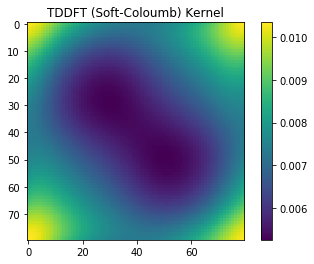

In [12]:
plt.title('TDDFT (Soft-Coloumb) Kernel')
plt.imshow(np.abs(F_LRC+F_Hartree)[::-1])
plt.colorbar()

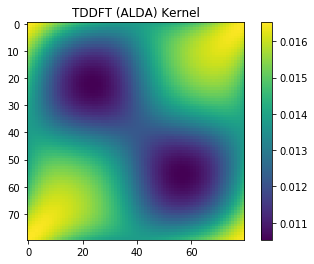

In [13]:
plt.title('TDDFT (ALDA) Kernel')
plt.imshow(np.abs(F_ALDA+F_Hartree)[::-1])
plt.colorbar()

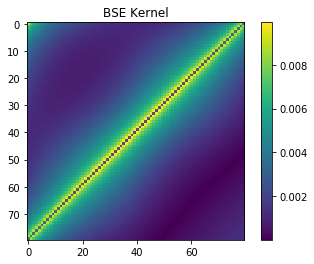

In [14]:
plt.title('BSE Kernel')
plt.imshow(np.abs(F_BSE+F_Hartree)[::-1])
plt.colorbar()

In [15]:
E_BSE,D_BSE=np.linalg.eigh(F_Free+F_Hartree+F_BSE)
E_LRC,D_LRC=np.linalg.eigh(F_Free+F_Hartree+F_LRC)
E_ALDA,D_ALDA=np.linalg.eigh(F_Free+F_Hartree+F_ALDA)

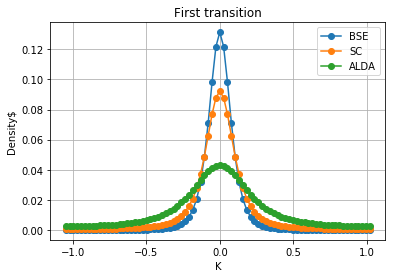

In [16]:
plt.title('First transition')
plt.plot(K,np.abs(D_BSE[:,0])**2,'-o',label='BSE')
plt.plot(K,np.abs(D_LRC[:,0])**2,'-o',label='SC')
plt.plot(K,np.abs(D_ALDA[:,0])**2,'-o',label='ALDA')
plt.ylabel('Density$')
plt.xlabel('K')
plt.legend(loc='best')
plt.grid()

In [17]:
print 'First transition:'
print 'BSE Energy: '+ str(E_Gap-E_BSE[0])
print 'SC Energy: ' + str(E_Gap-E_LRC[0])
print 'ALDA Energy: '+str(E_Gap-E_ALDA[0])

First transition:
BSE Energy: 0.07794606708213259
SC Energy: 0.12027149036646123
ALDA Energy: 0.4786446234818038


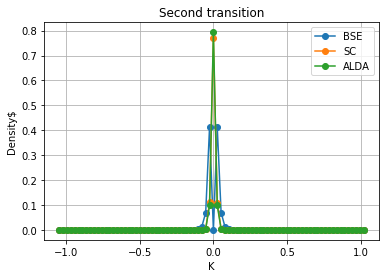

In [18]:
plt.title('Second transition')
plt.plot(K,np.abs(D_BSE[:,1])**2,'-o',label='BSE')
plt.plot(K,np.abs(D_LRC[:,1])**2,'-o',label='SC')
plt.plot(K,np.abs(D_ALDA[:,1])**2,'-o',label='ALDA')
plt.ylabel('Density$')
plt.xlabel('K')
plt.legend(loc='best')
plt.grid()

In [19]:
print 'Second transition:'
print 'BSE Energy: '+ str(E_Gap-E_BSE[1])
print 'SC Energy: ' + str(E_Gap-E_LRC[1])
print 'ALDA Energy: '+str(E_Gap-E_ALDA[1])

Second transition:
BSE Energy: -0.012519875755087062
SC Energy: -0.0007955603656477628
ALDA Energy: -0.0007538832313020993


# Spectrum

In [20]:
def spectrum(D,E,omega,eta):
    transition_dipole_matrix=np.zeros(N,dtype=np.complex)
    for i in range(N):
        v,c,k=indexes[i]
        operator=np.diag(K[k]+G)
        transition_dipole_matrix[i]=np.linalg.multi_dot([Dk[k,:,v],operator,Dk[k,:,c]])

    transition_element=np.zeros(N,dtype=np.complex)
    for i in range(N):
        transition_element[i]=np.linalg.multi_dot([D[:,i],np.diag(transition_dipole_matrix),D[:,i]])
        transition_element[i]=np.abs(transition_element[i])**2

    
    epsilon_M=np.zeros(omega.size,dtype=np.complex)
    for i in range(N):
        epsilon_M+=4*np.pi*transition_element[i]/(omega-E[i]+1j*eta)
    epsilon_M=1-epsilon_M
    return epsilon_M.imag

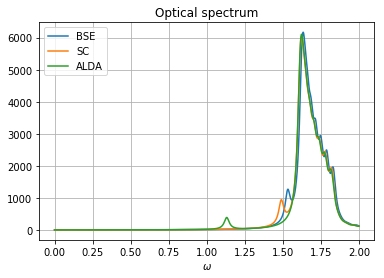

In [21]:
eta=0.02
omega=np.linspace(0,2,5000)
plt.title('Optical spectrum')
plt.plot(omega,spectrum(D_BSE,E_BSE,omega,eta),label='BSE')
plt.plot(omega,spectrum(D_LRC,E_LRC,omega,eta),label='SC')
plt.plot(omega,spectrum(D_ALDA,E_ALDA,omega,eta),label='ALDA')
plt.xlabel('$\omega$')
plt.legend(loc='best')
plt.grid()